In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Load the dataset
train_data = pd.read_csv('final_train.csv')
test_data = pd.read_csv('final_test.csv')

# Tokenize text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 100  # Maximum sequence length
X_train_text = tokenizer(train_data['text'].tolist(), padding='max_length', truncation=True, max_length=max_len, return_tensors='tf')
X_test_text = tokenizer(test_data['text'].tolist(), padding='max_length', truncation=True, max_length=max_len, return_tensors='tf')

# Convert labels to numerical format
label_mapping = {'bully-Spam': 0, 'not_bully-Spam': 1, 'bully-Ham': 2, 'not_bully-Ham': 3}
y_train = train_data['new_label'].map(label_mapping)
y_test = test_data['new_label'].map(label_mapping)

# Define BERT model
def build_bert_model():
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    bert_model = TFBertModel.from_pretrained("bert-base-uncased")
    bert_outputs = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    return Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=bert_outputs)

# Build BERT model
bert_model = build_bert_model()

# Combine BERT and LSTM models
def build_combined_model(bert_model):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    bert_output = bert_model([input_ids, token_type_ids, attention_mask])
    
    # Add LSTM layer
    lstm_output = LSTM(128)(bert_output)
    
    output = Dense(4, activation='softmax')(lstm_output)

    return Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=output)

# Build combined model
combined_model = build_combined_model(bert_model)

# Compile combined model with a smaller learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Adjust the learning rate as needed
combined_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train combined model with a smaller batch size
history = combined_model.fit(
    [X_train_text['input_ids'], X_train_text['token_type_ids'], X_train_text['attention_mask']], 
    y_train, 
    epochs=5, 
    batch_size=16, 
    validation_split=0.1
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
79/79 [==============================] - 520s 6s/step - loss: 0.7862 - accuracy: 0.6741 - val_loss: 0.5259 - val_accuracy: 0.8298
Epoch 2/5
79/79 [==============================] - 486s 6s/step - loss: 0.3885 - accuracy: 0.8723 - val_loss: 0.2345 - val_accuracy: 0.9504
Epoch 3/5
79/79 [==============================] - 484s 6s/step - loss: 0.2264 - accuracy: 0.9302 - val_loss: 0.1468 - val_accuracy: 0.9433
Epoch 4/5
79/79 [==============================] - 528s 7s/step - loss: 0.1197 - accuracy: 0.9667 - val_loss: 0.1662 - val_accuracy: 0.9504
Epoch 5/5
79/79 [==============================] - 526s 7s/step - loss: 0.0633 - accuracy: 0.9818 - val_loss: 0.1750 - val_accuracy: 0.9433


In [2]:
# Make predictions on test data
predictions = combined_model.predict([X_test_text['input_ids'], X_test_text['token_type_ids'], X_test_text['attention_mask']])

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the model
from sklearn.metrics import classification_report

# Convert test labels to numpy array
y_test_np = np.array(y_test)

# Print classification report
print(classification_report(y_test_np, predicted_labels))


14/14 [==============================] - 56s 4s/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.97      0.91      0.94       115
           2       0.81      0.87      0.84       103
           3       0.89      0.87      0.88       198

    accuracy                           0.89       426
   macro avg       0.88      0.92      0.89       426
weighted avg       0.89      0.89      0.89       426



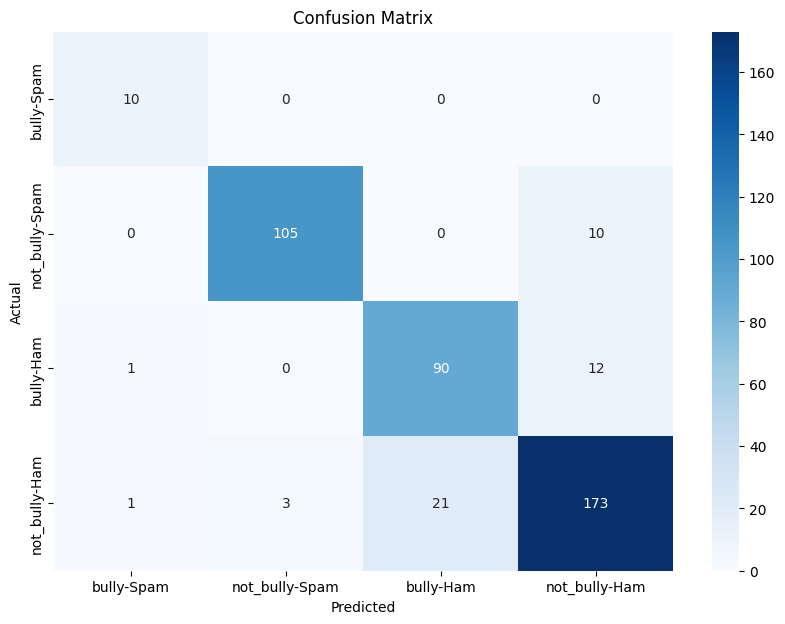

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_np, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
